# 🎮 Solving Mysteries with Code:A Sentiment and Topic Analysis of Mobile Detective Games (2023–2025)

This notebook presents a comprehensive analysis of **Google Play Store reviews** for seven popular mystery/adventure mobile games between **2023–2025**.  

<center>
  <img src="Solving_Mysteries.png" alt="Mystery Game Analysis" width="350"/>
  <br>
  <small><em>Storytelling, mystery-solving, and adventure — analyzed through player reviews</em></small>
</center>


# 🔎 Research Questions

This project investigates **user reviews of mystery/adventure mobile games** with a focus on player sentiment, review content, and predictive modeling. The main research questions are:

1. **Overall Sentiment**  
   - What is the distribution of **Positive, Neutral, and Negative** reviews for each game?  
   - Which games are most positively received by players?

2. **Sentiment Trends Over Time**  
   - How has player sentiment evolved for each game from **2023 to 2025**?  
   - Are there noticeable spikes or drops corresponding to game updates or events?

3. **Ratings vs Language**  
   - How do **star ratings (1–5)** align with the **sentiment of written reviews**?  
   - Are there cases where players leave high/low stars but write opposing text sentiment?  

4. **Review Themes & Topics**  
   - What **topics** (storyline, ads, bugs, graphics, difficulty) dominate discussions?  
   - Do positive vs negative reviews focus on different aspects?  

5. **Comparison of Sentiment Tools**  
   - How consistent are **TextBlob** and **VADER** sentiment scores?  
   - Where do the two methods disagree most often?  

6. **Predictive Modeling**  
   - Can a machine learning model accurately classify review sentiment?  
   - Which types of reviews are hardest for the model to predict correctly?  

---

## 🧰 Tools & Technologies Used

- **Python Libraries**:  
  - `pandas`, `numpy` → data handling  
  - `matplotlib`, `seaborn` → visualization  
  - `textblob`, `nltk` (VADER) → lexicon-based sentiment  
  - `scikit-learn` → TF-IDF, Logistic Regression, LDA topic modeling  
  - `wordcloud` → text visualization  

- **Data Source**:  
  - [Google Play Store reviews](https://play.google.com/store) scraped via `google-play-scraper`  

- **Games Analyzed**:  
  - *An Elmwood Trail: Criminal Story*  
  - *Adventure Escape: Hidden Ruins*  
  - *Murder in Alps: Hidden Mystery*  
  - *Harry Potter: Hogwarts Mystery*  
  - *Swordigo*  
  - *Layton Brothers Mystery Room*  
  - *Escape Room: Mystical Tales*

## Environment Setup

We install the libraries needed for scraping, text processing, visualization, topic modeling, and machine learning.

**Tools/Libraries**
- `google-play-scraper` — fetch Google Play reviews  
- `tqdm` — progress bars  
- `pandas`, `numpy` — data wrangling  
- `matplotlib`, `seaborn` — charts  
- `nltk`, `textblob` — sentiment analysis (rule/lexicon based)  
- `scikit-learn` — ML (TF-IDF, Logistic Regression, LDA)  
- `wordcloud` — quick term visualizations

> Run the `pip install …` cell once per environment.

In [ ]:
!pip install textblob nltk wordcloud scikit-learn seaborn matplotlib

## Imports

Load core Python libraries for:
- Data handling (`pandas`, `numpy`)
- Visualization (`matplotlib`, `seaborn`)
- Sentiment tools (`TextBlob`, `NLTK/VADER`)
- ML pipeline (`scikit-learn`)
- WordClouds
- Scraping (`google-play-scraper`)
- Progress tracking (`tqdm`)

In [4]:
# 📦 Install if missing
import pandas as pd
import numpy as np
import time, re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from textblob import TextBlob
import nltk
from google_play_scraper import reviews, Sort 
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 🚀 Missing imports (this fixes your error)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# download VADER lexicon if not available
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PMLS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Data Collection — Google Play Reviews

We scrape up to **1,600 reviews per game** (newest first), including:
- `content` (review text)
- `score` (1–5 stars)
- `at` (review date/time)
- `reviewId`, `userName`, etc.

We also save **per-game CSVs** and a single **merged CSV** for the whole corpus.

> This step populates the dataset used in the rest of the notebook.

In [22]:
# 🎮 Game list with package IDs
games = {
    "An Elmwood Trail: Criminal Story": "com.techyonic.textbasedrpg",
    "Adventure Escape: Hidden Ruins": "com.haikugamesco.escape11",
    "Murder in Alps: Hidden Mystery": "com.nordcurrent.murderinalps",
    "Harry Potter: Hogwarts Mystery": "com.tinyco.potter",
    "Swordigo": "com.touchfoo.swordigo",
    "Layton Brothers Mystery Room": "com.Level_5.MysteryRoomENG",
    "Escape Room: Mystical Tales": "air.com.hfg.mysticaltales"
}

max_reviews = 1600
all_dfs = []

# 🔄 Loop over games
for game_name, package_id in tqdm(list(games.items()), desc="📥 Scraping Games", unit="game"):
    print(f"\n🔎 Fetching reviews for: {game_name}")

    all_reviews = []
    next_token = None
    fetched = 0

    # Inner tqdm for reviews
    with tqdm(total=max_reviews, desc=f"   ⏳ {game_name}", unit="review") as pbar:
        while fetched < max_reviews:
            try:
                result, next_token = reviews(
                    package_id,
                    lang="en",
                    country="us",
                    sort=Sort.NEWEST,
                    count=200,
                    continuation_token=next_token
                )

                if not result:
                    break

                for r in result:
                    all_reviews.append({
                        "game": game_name,
                        "package_id": package_id,
                        "reviewId": r.get("reviewId"),
                        "userName": r.get("userName"),
                        "content": r.get("content"),
                        "score": r.get("score"),
                        "thumbsUpCount": r.get("thumbsUpCount"),
                        "reviewCreatedVersion": r.get("reviewCreatedVersion"),
                        "at": r.get("at").isoformat() if r.get("at") else None,
                        "replyContent": r.get("replyContent"),
                        "repliedAt": r.get("repliedAt").isoformat() if r.get("repliedAt") else None
                    })

                fetched += len(result)
                pbar.update(len(result))  # ✅ update progress bar

                if next_token is None:
                    break

                time.sleep(0.2)  # respectful delay

            except Exception as e:
                print(f"\n[❌ Error scraping {game_name}] {e}")
                break

    # Save per-game CSV
    df_game = pd.DataFrame(all_reviews)
    safe_name = re.sub(r"[^a-zA-Z0-9_]", "_", game_name.lower())
    filename = f"{safe_name}_reviews.csv"
    df_game.to_csv(filename, index=False)
    print(f"✅ Saved {len(df_game)} reviews → {filename}")

    all_dfs.append(df_game)
    time.sleep(0.5)

# 📂 Save merged CSV
if all_dfs:
    df_all = pd.concat(all_dfs, ignore_index=True)
    df_all.to_csv("all_games_reviews_merged.csv", index=False)
    print(f"\n📁 Merged file saved: all_games_reviews_merged.csv ({len(df_all)} reviews)")
else:
    print("⚠️ No reviews were scraped.")


📥 Scraping Games:   0%|          | 0/7 [00:00<?, ?game/s]


🔎 Fetching reviews for: An Elmwood Trail: Criminal Story



   ⏳ An Elmwood Trail: Criminal Story: 100%|██████████| 1600/1600 [00:38<00:00, 41.52review/s]


✅ Saved 1600 reviews → an_elmwood_trail__criminal_story_reviews.csv


📥 Scraping Games:  14%|█▍        | 1/7 [00:39<03:54, 39.13s/game]


🔎 Fetching reviews for: Adventure Escape: Hidden Ruins



   ⏳ Adventure Escape: Hidden Ruins: 100%|██████████| 1600/1600 [00:25<00:00, 63.62review/s]


✅ Saved 1600 reviews → adventure_escape__hidden_ruins_reviews.csv


📥 Scraping Games:  29%|██▊       | 2/7 [01:04<02:36, 31.25s/game]


🔎 Fetching reviews for: Murder in Alps: Hidden Mystery



   ⏳ Murder in Alps: Hidden Mystery: 100%|██████████| 1600/1600 [00:33<00:00, 47.27review/s]


✅ Saved 1600 reviews → murder_in_alps__hidden_mystery_reviews.csv


📥 Scraping Games:  43%|████▎     | 3/7 [01:39<02:10, 32.72s/game]


🔎 Fetching reviews for: Harry Potter: Hogwarts Mystery



   ⏳ Harry Potter: Hogwarts Mystery: 100%|██████████| 1600/1600 [00:27<00:00, 59.15review/s]


✅ Saved 1600 reviews → harry_potter__hogwarts_mystery_reviews.csv


📥 Scraping Games:  57%|█████▋    | 4/7 [02:06<01:32, 30.72s/game]


🔎 Fetching reviews for: Swordigo



   ⏳ Swordigo: 100%|██████████| 1600/1600 [00:40<00:00, 39.15review/s]


✅ Saved 1600 reviews → swordigo_reviews.csv


📥 Scraping Games:  71%|███████▏  | 5/7 [02:48<01:09, 34.57s/game]


🔎 Fetching reviews for: Layton Brothers Mystery Room



   ⏳ Layton Brothers Mystery Room: 100%|██████████| 1600/1600 [01:33<00:00, 17.05review/s]


✅ Saved 1600 reviews → layton_brothers_mystery_room_reviews.csv


📥 Scraping Games:  86%|████████▌ | 6/7 [04:22<00:54, 54.93s/game]


🔎 Fetching reviews for: Escape Room: Mystical Tales



   ⏳ Escape Room: Mystical Tales:  36%|███▌      | 573/1600 [01:44<03:07,  5.48review/s]


✅ Saved 573 reviews → escape_room__mystical_tales_reviews.csv


📥 Scraping Games: 100%|██████████| 7/7 [06:07<00:00, 52.57s/game]


📁 Merged file saved: all_games_reviews_merged.csv (10173 reviews)


## Load Data

Load the merged reviews file and quickly inspect shape and basic columns to confirm the scrape worked as expected.

In [5]:
# Load your merged reviews
df = pd.read_csv("all_games_reviews_merged.csv")
print("✅ Data loaded:", df.shape)
df.head()

✅ Data loaded: (10173, 11)


,game,package_id,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,An Elmwood Trail: Criminal Story,com.techyonic.textbasedrpg,faa60c8b-0a3c-4786-9a6b-b7327ac81f7b,Madiha Akhtar,no words..... just waiting for episode 4.,5,0,3.1.1,2025-09-08T09:49:48,NaN,NaN
1,An Elmwood Trail: Criminal Story,com.techyonic.textbasedrpg,d8673fe0-5ecd-429c-9704-2ad54e9241d7,Salma Eslam,so fun actually ♥️♥️♥️♥️♥️♥️♥️♥️,5,0,3.1.1,2025-09-08T09:03:59,NaN,NaN
2,An Elmwood Trail: Criminal Story,com.techyonic.textbasedrpg,c810b1e9-e396-4b85-804d-8fd6e62f8400,Kim Cuevas Mambulao,Not boring to play at all,4,0,3.1.1,2025-09-08T07:56:42,NaN,NaN
3,An Elmwood Trail: Criminal Story,com.techyonic.textbasedrpg,7966d395-2bff-46bf-8890-c1661911e01f,Angel Dequito,good,5,0,3.1.1,2025-09-08T07:44:43,NaN,NaN
4,An Elmwood Trail: Criminal Story,com.techyonic.textbasedrpg,dbe7219d-dd83-443f-8cf9-6a7de32f38ec,pu Maharjan,this game changed my life,5,0,3.1.1,2025-09-08T07:25:04,NaN,NaN


## Preprocessing & Heuristic Sentiment Labels

- Drop empty texts.
- Create a simple **ground-truth sentiment** from star ratings:
  - **Positive**: 4–5 stars
  - **Neutral**: 3 stars
  - **Negative**: 1–2 stars

These labels are used for descriptive analytics and to train/evaluate the ML model later.

In [6]:
# ==============================
# 2. 🧹 PREPROCESSING
# ==============================

df = df.dropna(subset=["content"]).copy()

# Label sentiment: Positive (4-5 stars), Negative (1-2 stars), Neutral (3 stars)
def label_sentiment(score):
    if score >= 4:
        return "Positive"
    elif score <= 2:
        return "Negative"
    else:
        return "Neutral"

df["sentiment"] = df["score"].apply(label_sentiment)

print(df["sentiment"].value_counts())

sentiment
Positive    8086
Negative    1334
Neutral      753
Name: count, dtype: int64


## Lexicon-Based Sentiment (TextBlob & VADER)

Compute two independent text-based sentiments:
- **TextBlob** polarity (−1 to +1) → map to Positive/Neutral/Negative
- **VADER** compound score (−1 to +1) → map to Positive/Neutral/Negative

We will later compare these to each other (RQ4) and to star ratings (RQ2).

In [8]:
# TextBlob polarity
df['polarity'] = df['content'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_label'] = df['polarity'].apply(
    lambda x: 'Positive' if x > 0.1 else ('Negative' if x < -0.1 else 'Neutral')
)

# VADER sentiment
sia = SentimentIntensityAnalyzer()
df['vader_score'] = df['content'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])
df['vader_sentiment'] = df['vader_score'].apply(
    lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral')
)

# Save sentiment data
df.to_csv("reviews_with_sentiments.csv", index=False)
print("✅ Sentiments saved → reviews_with_sentiments.csv")

✅ Sentiments saved → reviews_with_sentiments.csv


## RQ1 — Sentiment Distribution by Game

Visualize counts of **Positive/Neutral/Negative** reviews per game to see which titles have the strongest or weakest player sentiment at a glance.

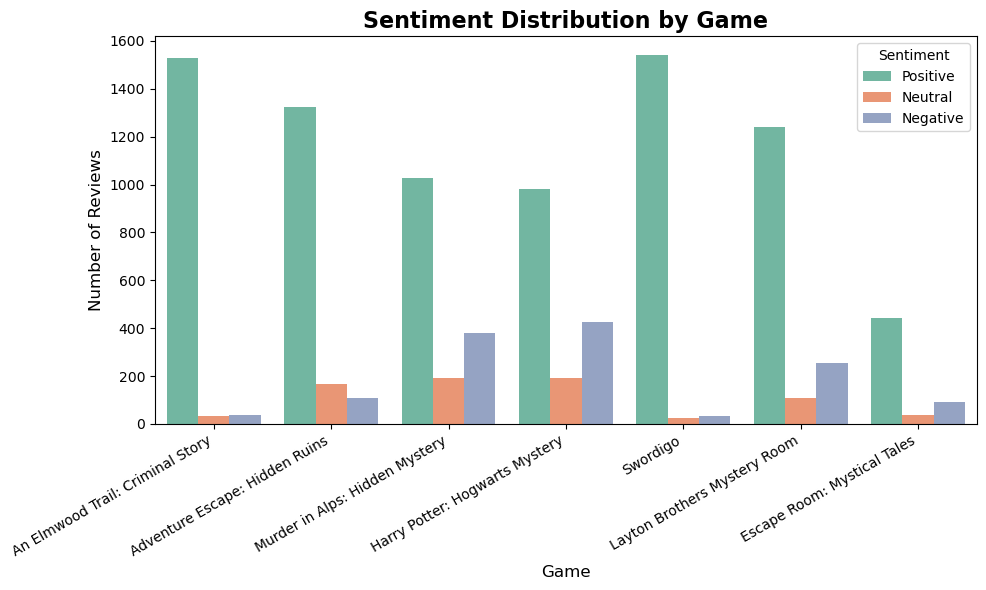

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="game", hue="sentiment", palette="Set2")

plt.title("Sentiment Distribution by Game", fontsize=16, weight="bold")
plt.xlabel("Game", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=30, ha="right")
plt.legend(title="Sentiment", loc="upper right")
plt.tight_layout()
plt.show()

## RQ2 — Sentiment Trends Over Time

Visualize how **average sentiment** for each game changes over time (monthly) to identify trends, spikes, or drops in player sentiment.  
This helps uncover whether certain updates, events, or game changes influenced player perception between **2023 and 2025**.


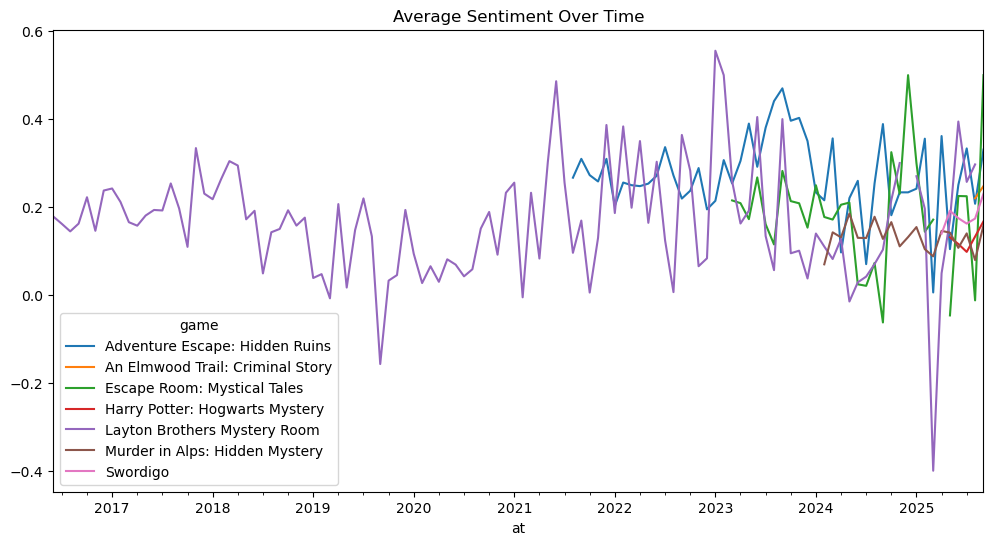

In [10]:
df['at'] = pd.to_datetime(df['at'])
sentiment_over_time = df.groupby([df['at'].dt.to_period('M'), 'game'])['polarity'].mean().unstack()
sentiment_over_time.plot(figsize=(12,6), title="Average Sentiment Over Time")
plt.show()

## Average Text Polarity by Game (TextBlob)

Compute and plot **mean TextBlob polarity** per game to compare overall tone in the review text across titles (complements RQ1).

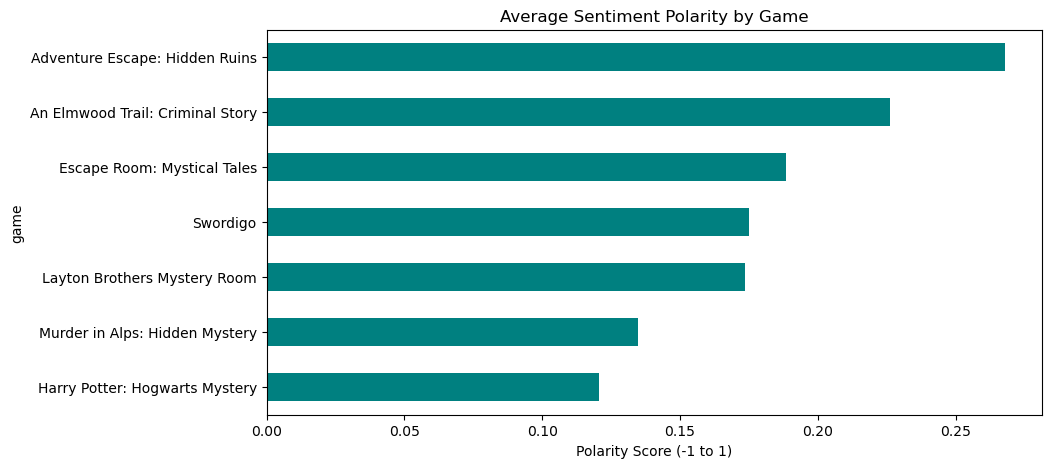

In [11]:
avg_polarity = df.groupby('game')['polarity'].mean().sort_values()

plt.figure(figsize=(10,5))
avg_polarity.plot(kind='barh', color='teal')
plt.title('Average Sentiment Polarity by Game')
plt.xlabel('Polarity Score (-1 to 1)')
plt.show()

## RQ3 — Relationship Between Stars and Text Sentiment

Compare numeric **star ratings** (1–5) with **TextBlob polarity** using a boxplot.  
This checks whether higher star ratings align with more positive language and vice versa.

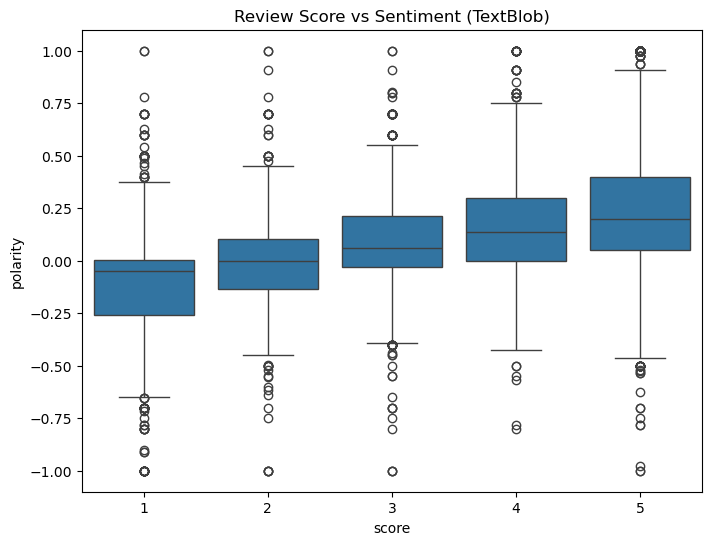

In [12]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='score', y='polarity')
plt.title("Review Score vs Sentiment (TextBlob)")
plt.show()

## RQ4 — TextBlob vs VADER Agreement

Create a heatmap (crosstab) of **TextBlob label vs VADER label** to assess agreement between the two lexicon-based methods and identify common mismatches.

Agreement between TextBlob & VADER: 71.81%


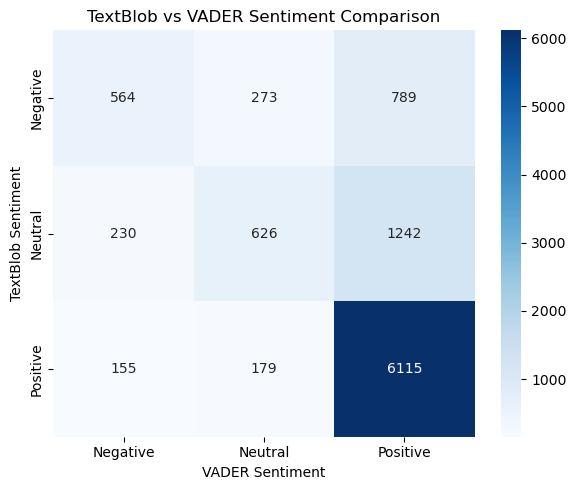

In [13]:
# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Step 1: Get polarity scores
df["textblob_sentiment"] = df["content"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df["vader_sentiment"] = df["content"].apply(lambda x: sia.polarity_scores(str(x))["compound"])

# Step 2: Convert to categorical
df["textblob_label"] = df["textblob_sentiment"].apply(lambda x: "Positive" if x > 0.05 else "Negative" if x < -0.05 else "Neutral")
df["vader_label"] = df["vader_sentiment"].apply(lambda x: "Positive" if x > 0.05 else "Negative" if x < -0.05 else "Neutral")

# Step 3: Agreement metric
agreement = (df["textblob_label"] == df["vader_label"]).mean()
print(f"Agreement between TextBlob & VADER: {agreement:.2%}")

# Step 4: Crosstab heatmap
plt.figure(figsize=(6,5))
sns.heatmap(
    pd.crosstab(df['textblob_label'], df['vader_label']),
    annot=True, fmt="d", cmap="Blues"
)
plt.title("TextBlob vs VADER Sentiment Comparison")
plt.xlabel("VADER Sentiment")
plt.ylabel("TextBlob Sentiment")
plt.tight_layout()
plt.show()

## RQ5 — Topic Modeling (LDA)

Apply **Latent Dirichlet Allocation (LDA)** to discover major themes in reviews:
- Minimal text cleaning (lowercasing + English stopwords)
- Vectorize with `CountVectorizer`
- Fit LDA (e.g., 5 topics)
- For each topic, extract top keywords and assign each review a **dominant topic**

This reveals recurring discussion areas (e.g., story, bugs, ads, difficulty).

In [14]:
# ==============================
# 🧹 1. Clean minimal text
# ==============================
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)   # keep only letters and spaces
    return text

df['cleaned'] = df['content'].astype(str).apply(clean_text)

# ==============================
# 🔠 2. Vectorize
# ==============================
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_vectorized = vectorizer.fit_transform(df['cleaned'])

# ==============================
# 📊 3. LDA Topic Modeling
# ==============================
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_vectorized)

# Assign dominant topic
lda_output = lda.transform(X_vectorized)
df['dominant_topic'] = lda_output.argmax(axis=1)

# Extract top words for each topic
topic_keywords = {}
for topic_idx, terms in enumerate(lda.components_):
    top_words = [vectorizer.get_feature_names_out()[i] for i in terms.argsort()[-10:]]
    topic_keywords[topic_idx] = ", ".join(top_words)

df['topic_keywords'] = df['dominant_topic'].map(topic_keywords)

# ==============================
# 💾 4. Save for Tableau
# ==============================
df[['game','content','score','sentiment','dominant_topic','topic_keywords']].to_csv(
    "reviews_topics_for_tableau.csv", index=False
)
print("✅ Topics saved → reviews_topics_for_tableau.csv")

✅ Topics saved → reviews_topics_for_tableau.csv


## Word Clouds for Positive vs Negative

Generate word clouds to visualize the most frequent terms in:
- **Positive** reviews (what players love)
- **Negative** reviews (pain points)

These are qualitative, exploratory summaries complementing the LDA topics.

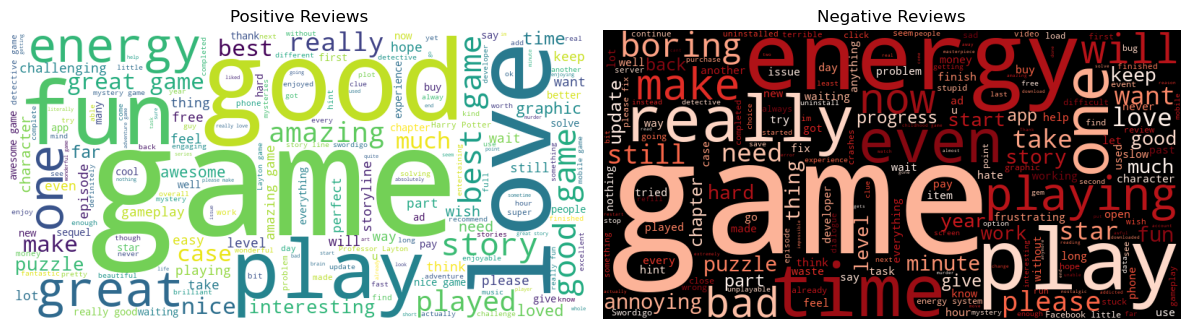

In [15]:
positive_text = " ".join(df[df['sentiment_label']=="Positive"]['content'].dropna().astype(str))
negative_text = " ".join(df[df['sentiment_label']=="Negative"]['content'].dropna().astype(str))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=800, height=400, background_color="white").generate(positive_text))
plt.axis("off")
plt.title("Positive Reviews")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(negative_text))
plt.axis("off")
plt.title("Negative Reviews")

plt.tight_layout()
plt.show()

## RQ6 — Train a Sentiment Classifier

Goal: predict **Positive/Neutral/Negative** from review text.

Pipeline:
- Train/test split (stratified)
- Text features via **TF-IDF** (top features, English stopwords)
- **Logistic Regression** classifier (simple, strong baseline)

We will evaluate with a classification report and a confusion matrix.

In [16]:
# Use the correct text and label columns
X = df["content"]       # review text
y = df["sentiment"]     # target labels

# Split into train/test
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Vectorize with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

## Model Evaluation — Reports & Confusion Matrices  

We test three classifiers: **Logistic Regression, Random Forest, and SVM**.  
For each, we show a **classification report** (precision, recall, F1) and a **confusion matrix** to compare performance and see where misclassifications occur.  


📌 Logistic Regression
              precision    recall  f1-score   support

    Negative       0.68      0.49      0.57       267
     Neutral       0.50      0.04      0.07       151
    Positive       0.86      0.98      0.92      1617

    accuracy                           0.84      2035
   macro avg       0.68      0.50      0.52      2035
weighted avg       0.81      0.84      0.81      2035



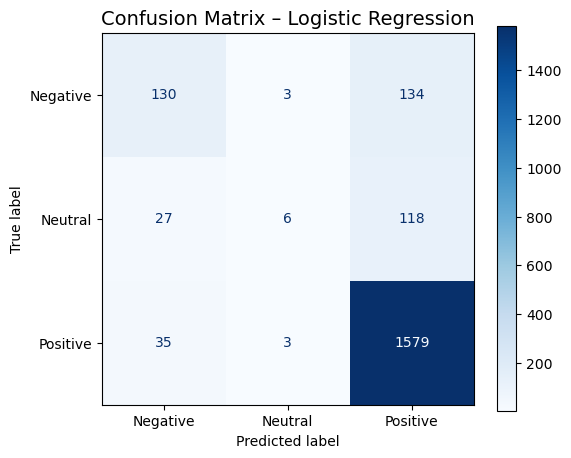


📌 Random Forest
              precision    recall  f1-score   support

    Negative       0.71      0.23      0.35       267
     Neutral       0.20      0.01      0.01       151
    Positive       0.82      0.99      0.90      1617

    accuracy                           0.82      2035
   macro avg       0.58      0.41      0.42      2035
weighted avg       0.76      0.82      0.76      2035



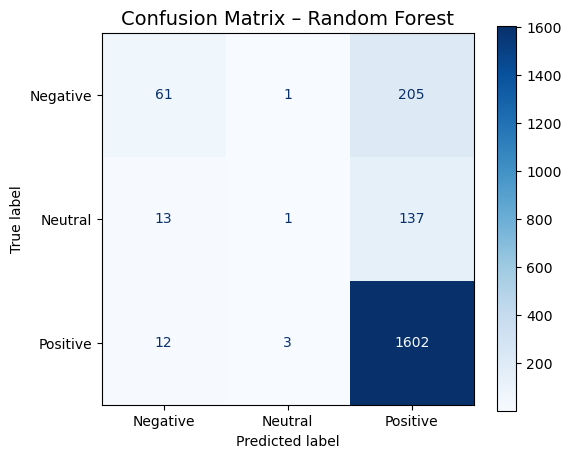


📌 SVM
              precision    recall  f1-score   support

    Negative       0.63      0.56      0.59       267
     Neutral       0.37      0.11      0.16       151
    Positive       0.89      0.96      0.92      1617

    accuracy                           0.85      2035
   macro avg       0.63      0.54      0.56      2035
weighted avg       0.82      0.85      0.82      2035



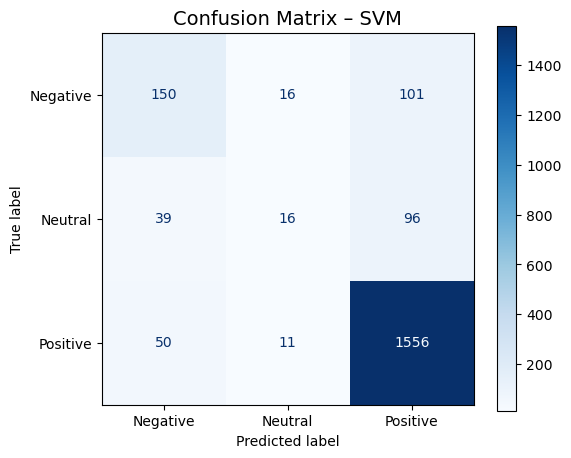

In [17]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": LinearSVC()
}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"\n📌 {name}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(6,5))
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap="Blues", ax=ax)
    plt.title(f"Confusion Matrix – {name}", fontsize=14)
    plt.show()

## Export Summaries for Tableau

Export aggregated results for fast dashboarding:
- `sentiment_summary.csv` — counts of Positive/Neutral/Negative per game

In [36]:
sentiment_summary = df.groupby(['game','sentiment_label']).size().reset_index(name="count")
sentiment_summary.to_csv("sentiment_summary.csv", index=False)
print("✅ Sentiment summary saved → sentiment_summary.csv")

✅ Sentiment summary saved → sentiment_summary.csv


## 📇 About the Author  


Written by **[Aleeza Zia](https://www.linkedin.com/in/aleeza-zia27)** · IBM Data Science Professional · Google Certified Data Analytics & Advanced Data Analytics Professional  

---
